# Global Mean SHAP Networks for German Credit dataset XGBoost Model

This notebook implements global mean aggregation to build a single network summarizing feature importance and interactions across all clients.

**Approach:** Aggregate SHAP values and interaction values across all clients using the mean, producing a single global network that captures the overall feature importance structure and pairwise interactions.

**Mathematical Framework:**
- **Node weights** aggregate individual SHAP values across all clients
- **Edge weights** aggregate interaction values, with the denominator normalized using only the **lower triangular** interaction matrix (u > v), excluding diagonal elements

In [1]:
import os
import sys
import shap
import numpy as np
import pandas as pd

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
# Load data
X = pd.read_pickle("../../../../data/credit/x_values.pkl")
num_clients = 500
X_shapley = X.iloc[:num_clients, :]
shap_values = np.load("../../../../data/credit/xgboost/shap_values.npy")
shap_interaction_values = np.load("../../../../data/credit/xgboost/shap_interaction_values.npy")

In [3]:
X_shapley.columns

Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'checking_status_<0', 'checking_status_>=200',
       'checking_status_no checking',
       'credit_history_critical/other existing credit',
       'credit_history_delayed previously', 'credit_history_existing paid',
       'credit_history_no credits/all paid', 'purpose_new car',
       'purpose_used car', 'purpose_business', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_other', 'purpose_radio/tv',
       'purpose_repairs', 'purpose_retraining', 'savings_status_500<=X<1000',
       'savings_status_<100', 'savings_status_>=1000',
       'savings_status_no known savings', 'employment_4<=X<7', 'employment_<1',
       'employment_>=7', 'employment_unemployed',
       'personal_status_male div/sep', 'personal_status_male mar/wid',
       'personal_status_male single', 'other_parties_guarantor',
       'other_parties_none', 'propert

## Compute Node Weights

**Node weights (N*_i):**
$$\mathcal{N}^*_i = \frac{\sum_{t=1}^{T} Sh_{i}(\Delta^{t})}{\sum_{u=1}^{n} \sum_{t=1}^{T} |Sh_{u}(\Delta^{t})|}$$

where $T$ is the total number of clients and $Sh_i(\Delta^t)$ is the SHAP value of feature $i$ for client $t$.

In [4]:
# Clean NaN values and compute denominator: sum of absolute SHAP values over all clients and features
shap_values = np.nan_to_num(shap_values)
sum_shap_values = np.sum(np.abs(shap_values), axis=(0, 1))

In [5]:
# Calculate node weights: N*_i = sum_t(Sh_i) / sum_u sum_t |Sh_u|
psi_1 = pd.DataFrame()
psi_1['value'] = np.sum(shap_values, axis=0) / sum_shap_values
psi_1.set_index(X_shapley.columns, inplace=True)

## Compute Edge Weights

**Edge weights (E*_ij):**
$$\mathcal{E}^*_{ij} = \frac{\sum_{t=1}^{T} I_{ij}(\Delta^{t})}{\sum_{v=1}^{n} \sum_{u > v}^{n} \sum_{t=1}^{T} I_{uv}(\Delta^{t})}$$

where $I_{ij}(\Delta^t)$ is the SHAP interaction value between features $i$ and $j$ for client $t$.

**Important:** The edge weight denominator sums only over the **lower triangular** part of the interaction matrix (where u > v), excluding diagonal elements. Diagonal elements represent individual feature effects and should be studied separately.

In [6]:
# Remove diagonal elements from the interaction matrix
# Diagonal elements hide inter-variable relations due to their magnitude
n_variables = shap_interaction_values.shape[1]
filtered_shap_interaction_values = np.nan_to_num(
    shap_interaction_values.copy()
)
idx_clients = np.repeat(np.arange(num_clients), n_variables)
idx_variables = np.tile(np.arange(n_variables), num_clients)
filtered_shap_interaction_values[
    idx_clients, idx_variables, idx_variables
] = 0

In [7]:
# Calculate denominator: sum of interaction values over all patients and feature pairs
sum_shap_interaction_values = np.sum(
    filtered_shap_interaction_values, axis=(0, 1, 2)
)

# Calculate numerator: cumulative interaction values summed over patients
cumulative_shap_interaction_values = np.sum(filtered_shap_interaction_values, axis=(0))

In [8]:
# Calculate edge weights: E*_ij = sum_t(I_ij) / sum_v sum_{u>v} sum_t |I_uv|
r_1 = pd.DataFrame(cumulative_shap_interaction_values / sum_shap_interaction_values)
r_1.rename(columns=dict(list(zip(r_1.columns, X_shapley.columns))), inplace=True)
r_1.set_index(X_shapley.columns, inplace=True)

In [9]:
# Normalize node and edge weights
psi_2 = normalize_psi(psi_1)
r_2 = normalize_r(r_1)

## Visualization Setup

In [10]:

shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3] 

## Visualize Global Mean Network

Threshold parameters control edge visibility:
- `positive_alpha = 0.07`: minimum threshold for positive edge weights
- `negative_alpha = 0.07`: minimum threshold for negative edge weights
- `positive_beta = 0`: upper threshold for positive edge weights
- `negative_beta = 0`: upper threshold for negative edge weights

Saving the graph to ..\..\..\..\result\credit_xgboost_global_mean_network.jpg


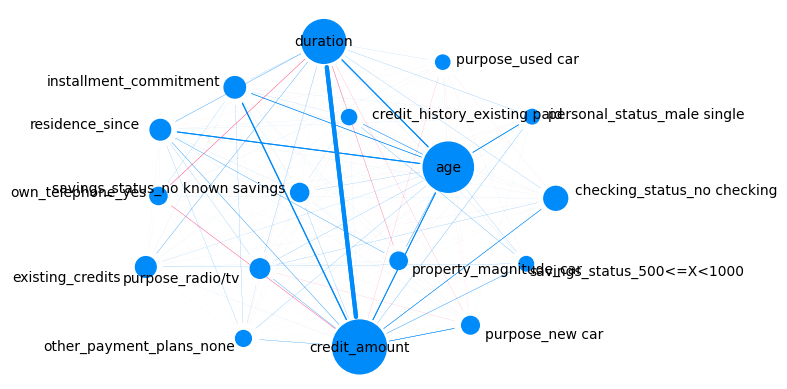

In [17]:
positive_alpha = 0.07
negative_alpha = 0.07
positive_beta = 0
negative_beta = 0
draw(
    psi=psi_2,
    r=r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
    label_color='black',
    label_weight='normal',
    output_path=os.path.join('..', '..', '..','..', 'result', 'credit_xgboost_global_mean_network.jpg')
)